<a href="https://colab.research.google.com/github/kay-squared/PyTorchLearn/blob/main/04_pytorch_CustomDatasets_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datsets Vidwo Notebook

**Reources:**
* Book version: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* github repo: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb
* Discussions on : https://github.com/mrdbourke/pytorch-deep-learning/discussions

We have used some datasets on Pytorch before, but how to you get your own data into Pytorch?

## Domain libraries
Depending on your problem (test, imiages, audio...), you may want to look into each of the PyTorch existinign data loading functions and customizable data loading functions

# 0. Import and set up device agnostic code


In [2]:
import torch
from torch import nn
torch.__version__

'1.13.1+cu116'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Download some data
* We will build food vision mini. SO get food dataset. Go to torchvision and check out datasets
* Use the Food181 data set of torchvision, but make it smaller
* find a Notebook which does so here: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb
* but the data are also provided on the deep learning repo of the course: https://github.com/mrdbourke/pytorch-deep-learning/tree/main/data so we will be using this


In [4]:
# Get dataset from github
import requests
import zipfile
from pathlib import Path 

# setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# make diretory if does not exist
if image_path.is_dir():
  print(f"{image_path} directory already exists ... Skipping download. ")
else:
  print(f"{image_path} does not exist, creatinig path.")
  image_path.mkdir(parents=True, exist_ok=True)

# download data into data path (raw link adress!)
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading Pizza Steak and Sushi data")
  f.write(request.content)

# unzip it into image path
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
  print(f"Unzipping Pizza Steak and Sushi data.")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi does not exist, creatinig path.
Unzipping Pizza Steak and Sushi data.


## 2. Data preparation and exploratioin

In [5]:
# walking through directory (standard imiage classification data)
import os
def walk_through_data(dir_path):
  """ Walks through dir_path and returns its content """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [6]:
walk_through_data(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


In [7]:
# Set up train and test paths - THIS IS STANDARD SETUP (there may also be a validation path)
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize image
1. Get all image paths
2. Pick a random image path using Pzthons random.choise()
3. Get the image class name using "pathlib.Path.parent.stem"
4. Open miage with python PIL
5. Show image and print metadata


Have a look at https://pytorch.org/vision/stable/utils.html. - there are tons of ways to manipuate and do stuff with images (including segementation adn bounding boxes)

In [8]:
import random
from PIL import Image

 Random image path: data/pizza_steak_sushi/train/sushi/773725.jpg
Image Class: sushi
Image height: 512
Image width: 382


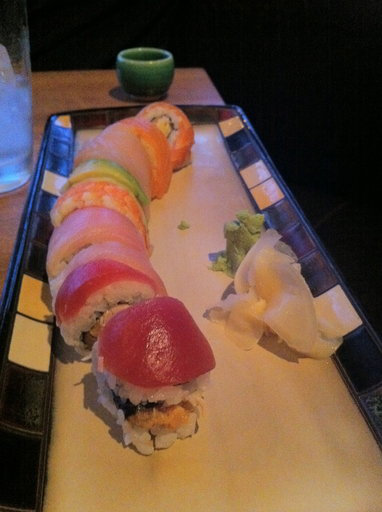

In [19]:
#random.seed(42)

# 1. Get image paths (all of them)
image_path_list = list ( image_path.glob("*/*/*.jpg") ) # mirrors depth of directory tree> test train / pizza steak sushi / jpg
#image_path_list

# 2. pick a random image
random_image_path = random.choice(image_path_list)
random_image_path

# 3. Get image class by looking at the name of the parent directory
image_class = random_image_path.parent.stem
image_class

# 4. use PIL  Image class to opem image
img = Image.open(random_image_path)

# 5. Print metadata
print(f" Random image path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

#

(-0.5, 381.5, 511.5, -0.5)

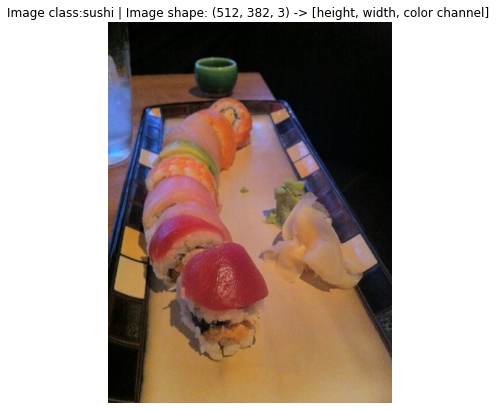

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# to plot with matplotlib, need to convert to numpy array
img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))

plt.imshow(img_as_array)
plt.title(f"Image class:{image_class} | Image shape: {img_as_array.shape} -> [height, width, color channel] ")
plt.axis(False)


# not that PIL has color channel last!!! unlike pytorch

## 3. Transforming data

1. Convert data to pytorch tensor format: here: numerical representaiton of images
2. turn it into a torch.utils.data.Dataset and subsequently into a torch.utils.data.DataLoader. We will call this Dataset and Dataloader

In [34]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transform data with torchvision.transforms

In [36]:
# transform from image
data_transform = transforms.Compose([
    # resize images to 64 x 64
    transforms.Resize(size=(64,64)),
    # Flip images randomly - useful for augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor() 
                                     ])

In [44]:
data_transform(img).shape
data_transform(img).dtype
data_transform(img)

tensor([[[0.0510, 0.0510, 0.0471,  ..., 0.0549, 0.0471, 0.0353],
         [0.0431, 0.0431, 0.0431,  ..., 0.0588, 0.0549, 0.0392],
         [0.0353, 0.0353, 0.0353,  ..., 0.0627, 0.0588, 0.0471],
         ...,
         [0.6510, 0.6667, 0.6824,  ..., 0.0157, 0.0157, 0.0157],
         [0.6627, 0.6784, 0.6980,  ..., 0.0235, 0.0314, 0.0392],
         [0.6549, 0.6706, 0.6941,  ..., 0.1333, 0.1490, 0.1647]],

        [[0.0510, 0.0510, 0.0471,  ..., 0.0627, 0.0549, 0.0392],
         [0.0431, 0.0431, 0.0431,  ..., 0.0667, 0.0627, 0.0471],
         [0.0392, 0.0392, 0.0353,  ..., 0.0745, 0.0667, 0.0549],
         ...,
         [0.5255, 0.5412, 0.5647,  ..., 0.0196, 0.0157, 0.0157],
         [0.5333, 0.5529, 0.5686,  ..., 0.0275, 0.0314, 0.0353],
         [0.5255, 0.5412, 0.5608,  ..., 0.1020, 0.1137, 0.1255]],

        [[0.0431, 0.0431, 0.0353,  ..., 0.0431, 0.0353, 0.0235],
         [0.0353, 0.0353, 0.0314,  ..., 0.0431, 0.0431, 0.0314],
         [0.0314, 0.0275, 0.0275,  ..., 0.0471, 0.0431, 0.

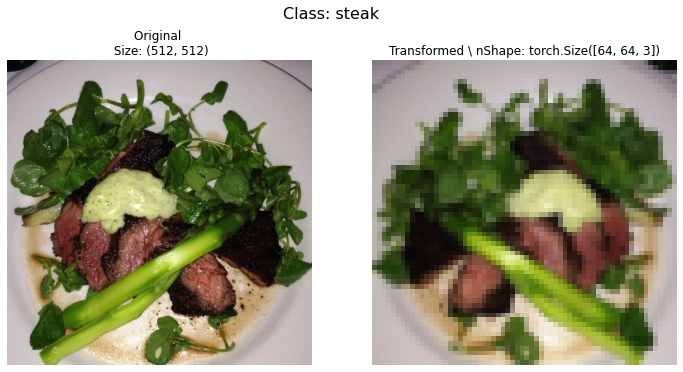

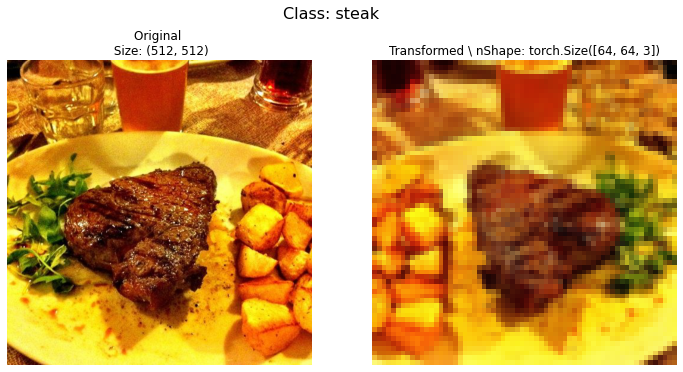

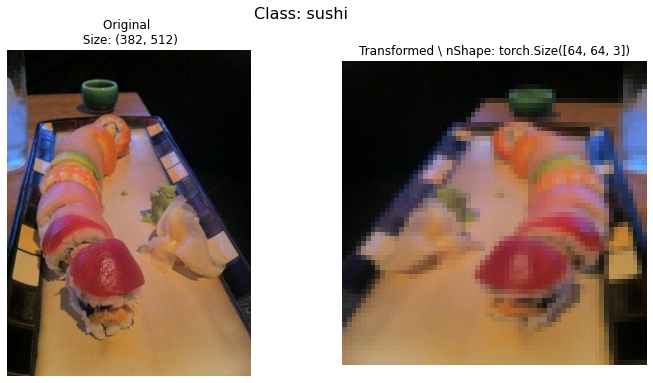

In [54]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  selects random image form the path list, loads and 
  transforms them, then plots original and transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)  # choose n images
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2,figsize=(12,6))
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size: {f.size}")
      ax[0].axis(False)

      # transform
      transformed_image = transform(f).permute(1,2,0)    # will need to change for matplotlib, because of color channels first
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \ nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list, 
                        transform = data_transform,
                        n=3,
                        seed=42)


## 4. Option 1: Loading image data using `ImageFolder`

Look at https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

We can load image classification data using `torchvision.datasets.ImageFolder`

Using this type of prebuit function is possible because the directory is in standard format for image classificatin







In [58]:
# use imagefolder
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform,
                                  target_transform=None)

In [60]:
train_data, test_data.classes


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), ['pizza', 'steak', 'sushi'])

#### Check out some attributes that come with `ImageFolder`
type train_data.   

and wait what comes up

In [63]:
# Get classnames as a list, this seems to be a built in class, but i dont know where the information comes from
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [64]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [65]:
# check the lengths of the dataset
len(train_data), len(test_data)

(225, 75)

In [71]:
# Get index on the train data set to get a single image and a labe
train_data[0]    # gibes image and label


img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: {img}")
print(f"Image shape: {img.shape}")
print(f"Image data=type: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09